# **DESI estimate galaxies & compare to SDSS paper**

In this notebook, I am exploring the DESI data, how to modify it or select parts of it. Currently I am working with the newest "full" realease, called Iron, which has all the nice Data Reduction already done.

This notebook includes (at least):
- import many libraries
- importing DESI Iron data
- reduce data dimensions (keep only certain columns, select objects in a 3D volume with good redshift, ...)
- calculate apparent and absolute magnitudes of each object
- plot apparent and absolute magnitudes
- compare plots/data to the SDSS DR 6 paper: https://arxiv.org/pdf/0806.4930.pdf
- calculate the coverage (for now only within DESI data) of flux, magnitudes and luminosities

## first steps (imports, info, inital data manipulation)

### imports, accessing the data

In [18]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel
import astropy
astropy.__version__

# needs to be at least version 5.1 to get the Schechter fit stuff

import matplotlib 
import matplotlib.pyplot as plt

import scipy as spy

import astropy.constants as asc

In [19]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3
from desitarget import targetmask            # main

In [20]:
from astropy.cosmology import Planck18, WMAP1
from astropy.coordinates import Distance
from astropy import units as u

from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy import units as u
import astropy.constants as asc

In [21]:
# import image module
from IPython.display import Image
 

In [22]:
change_bin_width = 0.7
# for plotting

In [23]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [24]:
# List everything in this directory
os.listdir(specprod_dir)

['healpix',
 'tiles',
 'exposures-iron.csv',
 'run',
 'calibnight',
 'exposures',
 'tiles-iron.fits',
 'processing_tables',
 'preproc',
 'inventory-iron.txt',
 'exposure_tables',
 'redux_iron.sha256sum',
 'exposures-iron.fits',
 'tiles-iron.csv',
 'zcatalog']

In [25]:
tiles_table = Table.read(f'{specprod_dir}/tiles-{specprod}.fits',)
print(f"Tiles table columns: {tiles_table.colnames}")

Tiles table columns: ['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


Now lets get the redshifts

In [26]:
# Listing all the available redshift catalogs

os.listdir(f'{specprod_dir}/zcatalog')

['ztile-special-dark-cumulative.fits',
 'zpix-main-dark.fits',
 'zpix-sv2-backup.fits',
 'logs',
 'zpix-sv3-bright.fits',
 'ztile-special-dark-pernight.fits',
 'zpix-special-backup.fits',
 'ztile-sv3-bright-pernight.fits',
 'ztile-sv1-bright-pernight.fits',
 'ztile-sv2-bright-pernight.fits',
 'zpix-sv3-dark.fits',
 'zpix-sv3-backup.fits',
 'ztile-main-dark-cumulative.fits',
 'ztile-sv1-dark-cumulative.fits',
 'zpix-sv1-bright.fits',
 'ztile-cmx-other-cumulative.fits',
 'zpix-cmx-other.fits',
 'ztile-special-backup-cumulative.fits',
 'zpix-sv2-dark.fits',
 'zpix-sv1-dark.fits',
 'ztile-sv3-backup-cumulative.fits',
 'ztile-special-bright-cumulative.fits',
 'ztile-sv1-other-cumulative.fits',
 'ztile-cmx-other-pernight.fits',
 'ztile-sv2-dark-cumulative.fits',
 'ztile-sv3-bright-cumulative.fits',
 'zpix-main-backup.fits',
 'redux_iron_zcatalog.sha256sum',
 'ztile-sv2-dark-pernight.fits',
 'zall-pix-iron.fits',
 'ztile-special-other-cumulative.fits',
 'ztile-sv3-backup-pernight.fits',
 'zti

### get the raw data

In [27]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")
ztile_unm = ztile_cat.copy()

In [28]:
np.max(ztile_cat["LASTNIGHT"])

20220613

In [29]:
ztile_cat[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int32,bool,int64,bool
616089235992085010,cmx,other,20201216,20201216,1.026539591165917,0.00014994197241333243,5,8924.357209771872,-24.07681142832455 .. 1.8223517485788985,7928,GALAXY,--,10,8.939738029614091,0,311,311,0,0,23.64704835712534,30.237699207256,0.0,0.0,0.0,5400.0,4294967296,4,SKY,81.98283,-286.4917,-1,0.8849026730392795,63,9010,0235p302,497013,530,--,0.0532665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0565887,-0.124679565,-0.18450871,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,--,-1,-1,4294967296,4294967296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.64704835712534,30.237699207256,80615,4,3600.0,1,1,-0.00225,0.005267827,-0.00075,0.0040311287,23.647058848068063,0.09217804,30.23769623069657,0.055068973,0.79220617,81.9705,-286.4835,413.26205,0.2375252,78.07899,197.2936,1279.8805,563.71747,6.3496313,2.2683153,33883.484,71.459564,6052.3867,0.13865727,6896.178,37894.566,22.27903,103.9056,5.3238196e-05,238.68176,1.0061857e-05,0.0,10528.6875,7.3067626e-05,49.533707,109.42108,34296.746,310.37885,6130.466,197.43225,18704.746,38458.285,78.16237,215.595,0,False,0,False,1,True
616089272318951842,cmx,other,20201216,20201216,0.9703405618899601,7.493299654729945e-05,5,8379.292280852795,-10.447763104563462 .. -0.37425000545091947,7927,GALAXY,--,10,0.2723734676837921,6,134,6134,3336,0,24

### DESI coverage at the time of the used data release (13.6.22)

In [30]:
Image(url="Images/DESI coverage IRON.png", width = 800)

In [31]:
ztile_cat[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int32,bool,int64,bool
616089235992085010,cmx,other,20201216,20201216,1.026539591165917,0.00014994197241333243,5,8924.357209771872,-24.07681142832455 .. 1.8223517485788985,7928,GALAXY,--,10,8.939738029614091,0,311,311,0,0,23.64704835712534,30.237699207256,0.0,0.0,0.0,5400.0,4294967296,4,SKY,81.98283,-286.4917,-1,0.8849026730392795,63,9010,0235p302,497013,530,--,0.0532665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0565887,-0.124679565,-0.18450871,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,--,-1,-1,4294967296,4294967296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.64704835712534,30.237699207256,80615,4,3600.0,1,1,-0.00225,0.005267827,-0.00075,0.0040311287,23.647058848068063,0.09217804,30.23769623069657,0.055068973,0.79220617,81.9705,-286.4835,413.26205,0.2375252,78.07899,197.2936,1279.8805,563.71747,6.3496313,2.2683153,33883.484,71.459564,6052.3867,0.13865727,6896.178,37894.566,22.27903,103.9056,5.3238196e-05,238.68176,1.0061857e-05,0.0,10528.6875,7.3067626e-05,49.533707,109.42108,34296.746,310.37885,6130.466,197.43225,18704.746,38458.285,78.16237,215.595,0,False,0,False,1,True
616089272318951842,cmx,other,20201216,20201216,0.9703405618899601,7.493299654729945e-05,5,8379.292280852795,-10.447763104563462 .. -0.37425000545091947,7927,GALAXY,--,10,0.2723734676837921,6,134,6134,3336,0,24

In [32]:
len(ztile_cat)

30300000

### reduce data dimensions & calculate current volume
only keep certain columns (maybe use different ones e.g. MEAN_FIBER_DEC might be the better choice than TARGET DEC..., but for now this should be ok):
- TARGETID (unique ID per object)
- SURVEY (Main, EDR,...)
- PROGRAM (bright, dark)
- Z (redshift and ZERR is its error)
- ZWARN (whether something went wrong in calculating the redshfit)
- TARGET_RA & TARGET_DEC
- FLUX_Z (z-band flux)


***NOTE ON THE FLUX***

There are several values that are have "flux" in their names in the DESI data. Here is a short summary (copied from https://www.legacysurvey.org/dr10/catalogs/), what each of these mean (I am leaving out _g/_r ... for clarity):
- **flux**: model flux [nanomaggy]
- **flux_ivar**: inverse variance of flux [1/nanomaggy^2]
- **fiberflux**: predicted flux within a fiber of diameter 1.5 arcsec from *this object* in 1 arcsec Gaussian seeing [nanomaggy]; "It also provides galactic extinction measurements derived from the Schlegel et al. (1997) (SFD98) maps", quoting ChangHoon et al. (2022) (DESI BGS: Final Target Selection, Design and Validation)
- **fibertotflux**: Predicted flux within a fiber of diameter 1.5 arcsec from *all sources at this location* in 1 arcsec Gaussian seeing [nanomaggy]
- **apflux**: Aperture fluxes on the co-added images in apertures of radius [0.5, 0.75, 1.0, 1.5, 2.0, 3.5, 5.0, 7.0] arcsec, masked by 𝑖𝑛𝑣𝑣𝑎𝑟=0 (inverse variance of zero) [nanomaggy]
- apflux_resid: Aperture fluxes on the co-added residual images, masked by 𝑖𝑛𝑣𝑣𝑎𝑟=0 [nanomaggy]
- apflux_ivar: Inverse variance of apflux_resid_g, masked by 𝑖𝑛𝑣𝑣𝑎𝑟=0 [1/nanomaggy^2]
- ...


After that we perform the steps to include only those galaxies we are interested in:
- select only ZWARN == 0 galaxies (i.e. no problems in evaluation of z)
- select certain redshift range
- select certain area (ra and dec)
- use only good z-flux values
- (use only bright sample (for now))

In [33]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_Z', 'LASTNIGHT'])

In [34]:
# "NPIXELS", "DEVICE_LOC", "LOCATION", "FIBER", "PMRA", "PMDEC", "REF_EPOCH", "LAMBDA_REF", "FA_TARGET", "FA_TYPE", "FIBERASSIGN_X", "FIBERASSIGN_Y", "PRIORITY", "SUBPRIORITY", "RELEASE", "BRICKNAME", "BRICKID", "BRICK_OBJID"

In [35]:
#ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [36]:
#print("current number of data entries (ZWARN step): ", len(ztile_cat))

In [37]:
# center: 0.036 +- 0.016
# center 2: 0.202  +- 0.042
# center GW170817 (need other dec, ra tho, bc DESI): 0.0093+-0.002
z_max, z_min = 0.0093+0.002, 0.0093-0.002  # these are the z-band values from the SDSS paper (NOT ANYMORE: TO PLOT FOR GW DAY EVENT I CHANGED FROM 0.02, 0.23

In [38]:
ztile_cat = ztile_cat[(ztile_cat['Z']< z_max)&(ztile_cat['Z'] > z_min)]

In [39]:
ztile_cat[0:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_Z
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32
616094198168290363,main,backup,20220510,0.0076348348866155935,6.008566334435069e-05,5,203.1776811675338,65.35077810576142,0.0
616094187778999406,main,backup,20220510,0.008543083386911345,0.00010743407408785596,5,199.7658427837975,64.36392441280987,0.0
2305843036547977900,main,backup,20220412,0.008943456031699198,7.256451436996485e-05,4,218.20857502984657,4.2142322896841815,-99.0
616088522406756557,main,backup,20220203,0.008103814295350462,4.301002273899701e-05,5,208.28063365923043,-0.8405707290901155,0.0
616088486126027438,main,backup,20220605,0.008751387567632494,2.8039404933528186e-05,1,205.84211585096645,-2.2337337995766187,0.0


In [40]:
print("current number of data entries (z-range selection):", len(ztile_cat))

current number of data entries (z-range selection): 18824


In [41]:
min_ra = 180
min_dec = -2
max_ra = 184
max_dec = 2

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 16.00 sqdeg


In [42]:
deg_to_rad = np.pi/180

def simple_cubiod_volume(dist_min, dist_max, ra, dec):

    """
    Calculates the volume in Mpc^3 (the search area), right now simply by taking 1/2 of the volume that two cuboids
    (simply the flat planes at min and max distance) contain. In future one could refine this by calculating the actual
    spherically shaped volume.
    """

    angular = np.tan(ra*deg_to_rad/2)*np.tan(dec*deg_to_rad/2)
    plane1 = 4*(dist_min**2)*(angular)
    plane2 = 4*(dist_max**2)*(angular)
    volume = (dist_max-dist_min)*(plane1+plane2)/2

    #volume2 = (dist_max-dist_min)*(dist_min*np.tan(ra*deg_to_rad/2)*dist_min*np.tan(dec*deg_to_rad/2)*4+dist_max*np.tan(ra*deg_to_rad/2)*dist_max*np.tan(dec*deg_to_rad/2)*4)/2
    return(volume)

# this data should be read from a file instead of manually typing, but for now...
# e.g. S190503bf had 448 deg^2 and 421+-105Mpc or S191216ap had 253 deg^2 and 376±70Mpc distance or very bad: S190706ai had 826deg^2, 5263±1402Mpc

ra_dist = max_ra-min_ra        # region of interest in degrees for ra (this is from left to right tho, not the center)
dec_dist = max_dec-min_dec       # region of interest in degrees for dec (this is from bottom to top tho, not the center)

dist, dist_min, dist_max = Distance(z=(z_max+z_min)/2, cosmology=Planck18), Distance(z=z_min, cosmology=Planck18), Distance(z=z_max, cosmology=Planck18) # Luminosity distance measured from LIGO in Mpc
# how does this change for different cosmologies?


curr_vol = simple_cubiod_volume(dist_min, dist_max, ra_dist, dec_dist)
print(curr_vol)

158.18343555947888 Mpc3


In [43]:
ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

ztile_cat = ztile_cat[ii]

In [44]:
ztile_cat[0:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_Z
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32
-205918256,main,bright,20220430,0.0073683066138095455,4.45961788369818e-05,2053,182.59337276097926,-0.9215555513394009,0.0
39627775719507449,main,bright,20220430,0.007666904068265811,2.490057201992721e-06,0,183.06620815121173,-0.5647622190034115,52.97464
2389564224176130,main,bright,20220515,0.007357106181241604,2.1454103718268374e-05,0,182.82877832642163,1.4998254859152529,0.0
-220665230,main,bright,20220407,0.008099417514297528,5.0808635927166495e-05,2564,180.82014770367422,-0.3047806423733381,0.0
-220664310,main,bright,20220407,0.007634138873539075,5.397218975794561e-05,2564,180.428897382283,-0.2858622919225856,0.0


In [45]:
print("current number of data entries (area selection): ", len(ztile_cat))

current number of data entries (area selection):  165


In [46]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [47]:
print("current number of data entries (zwarn selection): ", len(ztile_cat))

current number of data entries (zwarn selection):  40


In [48]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]

In [49]:
ztile_cat[0:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_Z
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32
39627775719507449,main,bright,20220430,0.007666904068265811,2.490057201992721e-06,0,183.06620815121173,-0.5647622190034115,52.97464
39627757604310086,main,bright,20220213,0.008124939768211239,5.242919408498268e-07,0,183.41167957835154,-1.2935382938813083,73.72643
39627787799102855,main,bright,20220321,0.00773225193106879,1.1318860758684561e-05,0,183.06097066965458,0.07404964552594072,27.872553
39627757566562669,main,bright,20211219,0.010322703271150702,4.258315566518117e-06,0,181.23956703622267,-1.3502027476642355,20.211142
39627787769741957,main,bright,20220210,0.008312995070466662,6.753604815670366e-06,0,181.27964889788277,-0.1105611665825349,71.397934


In [50]:
print("current number of data entries (z-band flux bad value deletion): ", len(ztile_cat))

current number of data entries (z-band flux bad value deletion):  38


In [51]:
# ztile_cat = ztile_cat[ztile_cat["PROGRAM"]== "bright"]

In [52]:
# print("current number of data entries (bright program selection): ", len(ztile_cat))

In [53]:
# ztile_cat[0:5]

In [54]:
len(ztile_cat)

38

In [55]:
np.max(ztile_cat["FLUX_Z"])

637.9104

In [56]:
(ztile_cat["FLUX_Z"] == 0.0).sum()

0

In [57]:
np.count_nonzero(ztile_cat["FLUX_Z"]<1000)

38

In [58]:
np.sum(ztile_cat["FLUX_Z"])

1746.5665

In [59]:
above_threshold = ztile_cat[ztile_cat["FLUX_Z"]>1000]

In [60]:
above_threshold

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_Z
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32


In [61]:
np.sum(above_threshold["FLUX_Z"])

0.0

In [62]:
np.sum(above_threshold["FLUX_Z"])/np.sum(ztile_cat["FLUX_Z"])

0.0

## Calculate absolute & apparent magnitudes from fluxes for further analysis, short data overview

From the z-band fluxes we first calculate the absolute magnitudes, according to https://www.legacysurvey.org/dr10/description/ :$$m = 22.5-2.5log_{10}(flux)$$) and $$M = m - 5*\log_{10}(d_{pc})+ 5$$

The steps here are very similar/the same as described in the SDSS paper!

**this is currently possibly missing a redshift correction**

In [63]:
# calculate the absolute and apparent magnitude of every galaxy (Planck Cosmology)
app_mag = [22.5-2.5*np.log10(ztile_cat["FLUX_Z"][q]) for q in range(len(ztile_cat["FLUX_Z"]))]
abs_mag = [(app_mag[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_Z"]))]

In [64]:
abs_mag[:10], len(abs_mag)

([-14.478403887306818,
  -14.964045942978316,
  -13.799712946223401,
  -14.082440068785559,
  -14.979198057037422,
  -16.811492713269146,
  -14.268716037307698,
  -14.075171623963236,
  -14.337195603524236,
  -9.934051188400076],
 38)

In [65]:
np.min(abs_mag) # shows the minimal absolute magnitude in the sample

-17.228912804092865

In [66]:
# get the limits of the absolute magnitudes (for integration and more), define the number of bins
# (scales with higher difference in mags)
upper_limit_abs = np.max(abs_mag)
lower_limit_abs = np.min(abs_mag)
num_of_bins_abs = int((upper_limit_abs - lower_limit_abs)*100)

print("The number of abs mag bins is: ", num_of_bins_abs)
print("The abs mag bin width is: ", (upper_limit_abs-lower_limit_abs)/num_of_bins_abs)

The number of abs mag bins is:  788
The abs mag bin width is:  0.010007905780016084


In [67]:
# get the limits of the apparent magnitudes (for integration and more), define the number of bins
# (scales with higher difference in mags) and evenly divide the magnitudes (e.g. for plotting)
upper_limit_app = np.max(app_mag)
lower_limit_app = np.min(app_mag)
num_of_bins_app = int((upper_limit_app - lower_limit_app)*100)

print("The number of bins is: ", num_of_bins_app)
print("The bin width is: ", (upper_limit_app-lower_limit_app)/num_of_bins_app)

The number of bins is:  803
The bin width is:  0.010007381030957992


### Important Notice about the graphs!

The choice of ***the bin width*** changes the plot below **significantly**! The smaller the bins, the fewer galaxies per bin, of course. For here, I choose very small bins for illustration, but three steps further down I will use the bigger bins (similar to the SDSS paper and their "N_euclidean" count).

In [68]:
# this just sorts the magnitudes in an ascending manner, i.e. the lowest value of magnitude becomes the first entry
# abs_mags_sort = np.sort(abs_mag)

# create the histogramm (i.e. x values are the mags, y values are the number of occurences per bin)
N_abs, mags_abs_binned = np.histogram(abs_mag, bins = num_of_bins_abs, range = (lower_limit_abs, upper_limit_abs))
N_abs[:10]

N_app, mags_app_binned = np.histogram(app_mag, bins = num_of_bins_app, range = (lower_limit_app, upper_limit_app))
N_app[:10]


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Getting an idea about the data

For now I just plot the data, with a more or less arbitrary size/number of bins.

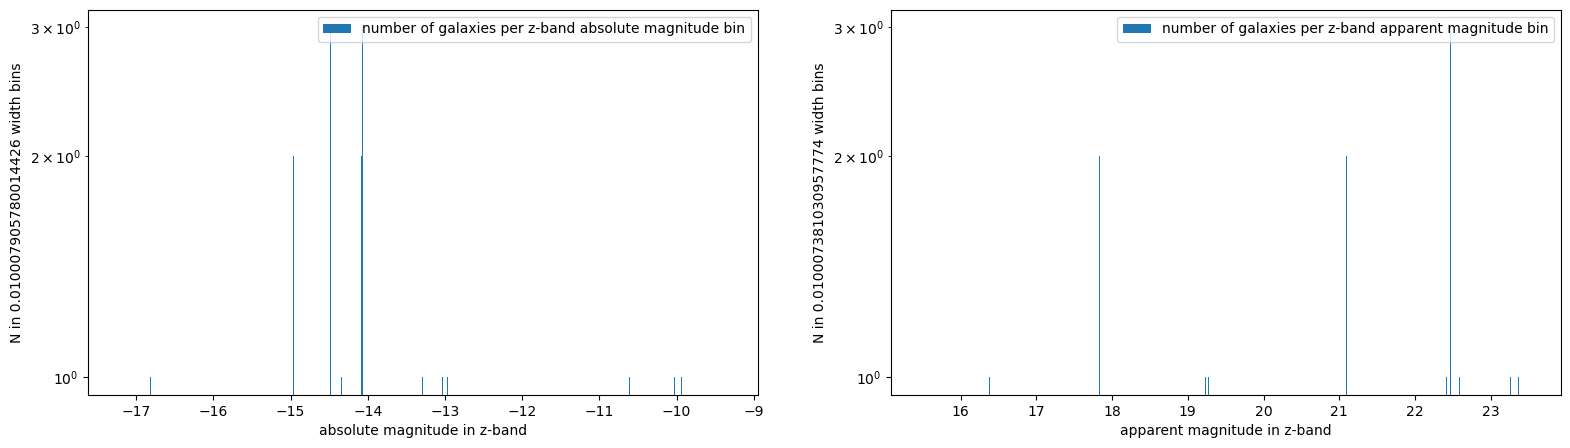

In [69]:
fig, ax = plt.subplots(ncols = 2, figsize=(19, 5))
width_abs_mags = change_bin_width * (mags_abs_binned[1] - mags_abs_binned[0])
center_abs_mags = (mags_abs_binned[:-1] + mags_abs_binned[1:])/2

ax[0].bar(center_abs_mags, N_abs,  align = "center", width = width_abs_mags, label = "number of galaxies per z-band absolute magnitude bin")
ax[0].set_xlabel("absolute magnitude in z-band")
y_label_abs = "N in " + str(width_abs_mags/change_bin_width) + " width bins"
ax[0].set_ylabel(y_label_abs)
ax[0].set_yscale('log')
ax[0].legend(loc = "upper right")


width_app_mags = change_bin_width * (mags_app_binned[1] - mags_app_binned[0])
center_app_mags = (mags_app_binned[:-1] + mags_app_binned[1:])/2

ax[1].bar(center_app_mags, N_app,  align = "center", width = width_app_mags, label = "number of galaxies per z-band apparent magnitude bin")
ax[1].set_xlabel("apparent magnitude in z-band")
y_label_app = "N in " + str(width_app_mags/change_bin_width) + " width bins"
ax[1].set_ylabel(y_label_app)
ax[1].set_yscale('log')
ax[1].legend(loc = "upper right")

plt.show()

## Comparing to SDSS paper

Here I compare this data to the SDSS paper:

- total count N in half mag bin per deg^2 vs. apparent magnitude (including with $$N_{euclidean}$$ scaling)
- total count N in half mag bin per deg^2 vs. absolute magnitude
- plot the Schechter function from the SDSS paper (basicall logN vs absolute mag)
- some other validation/training plots/calcs

The formula for the scaling is: $$ N_{euclidean} = 10^{0.6(m-18)} $$

If either bin width or redshift range differs from the paper one canoot meaningfully compares the numbers, however, the general shape should stay the same.

DESI z-band and SDSS z-band are somewhat different:
- DESI: mean at 925nm, delta of 150nm
- SDSS: mean at 885nm, delta of 120nm

In [70]:
def eucl(m):
    return 10**-(0.6*(m-18))

In [71]:
# this time we want the bin width to be exactly 0.5 magnitudes as in the paper.
bins_app = np.arange(lower_limit_app, upper_limit_app, 0.5)
bins_abs = np.arange(lower_limit_abs, upper_limit_abs, 0.5)

In [72]:
bins_app[:5]

array([15.48810065, 15.98810065, 16.48810065, 16.98810065, 17.48810065])

In [73]:
# create the histogramm (i.e. x values are the mags, y values are the number of objects per magnitude bin)
N_abs_big, mags_abs_binned_big = np.histogram(abs_mag, bins = bins_abs)

N_app_big, mags_app_binned_big = np.histogram(app_mag, bins = bins_app)

In [74]:
N_euc_app = eucl((bins_app[:-1] + bins_app[1:])/2)

In [75]:
N_euc_app[:5]

array([22.75828917, 11.40616399,  5.71662378,  2.86509886,  1.43595097])

Now lets first have a look at what we can expect from the SDSS paper:

In [76]:
Image(url="Images/SDSS apparent mag vs logN.png", width = 600)

In [77]:
Image(url="Images/SDSS abs mag vs N.png", width = 600)

And now plot our own data

(for above: if h = 0 -> obv no shift, if h = 0.7 then shift by ~0.77)

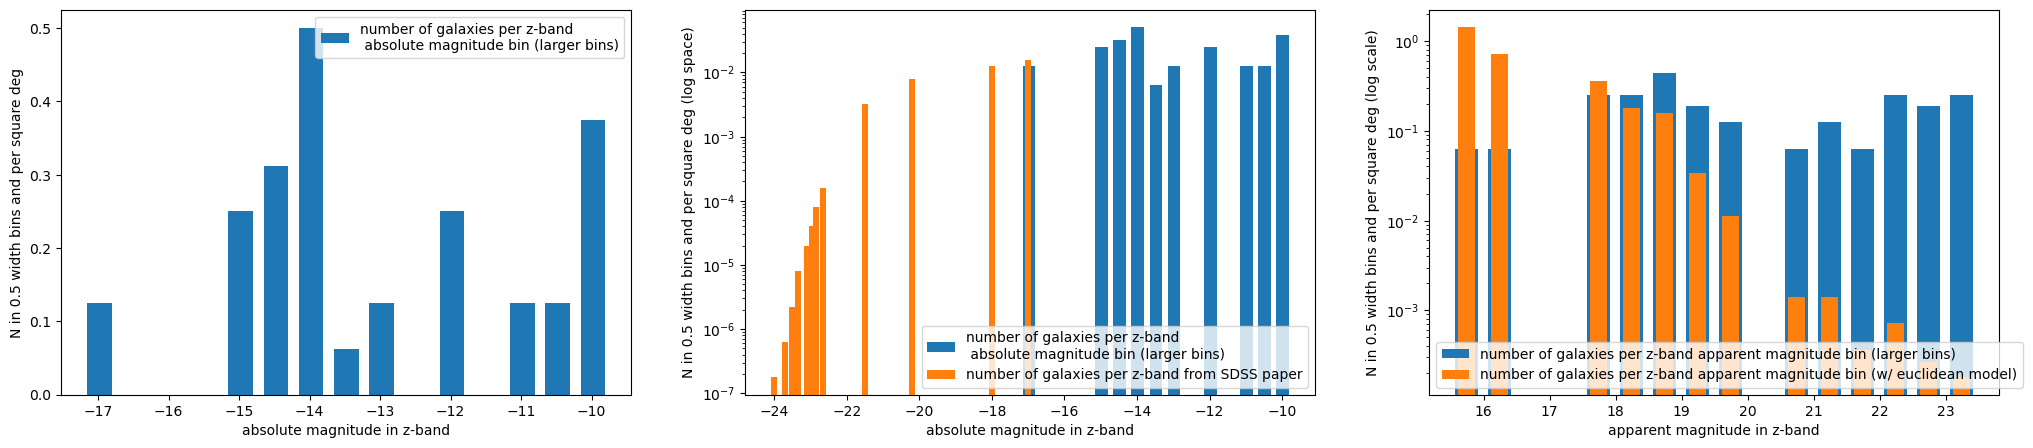

In [78]:
# Now lets plot these
fig, ax = plt.subplots(ncols = 3, figsize=(25, 5))

width_abs_mags_big = change_bin_width * (mags_abs_binned_big[1] - mags_abs_binned_big[0])
center_abs_mags_big = (mags_abs_binned_big[:-1] + mags_abs_binned_big[1:])/2

ax[0].bar(center_abs_mags_big, N_abs_big/area,  align = "center", width = width_abs_mags_big, label = "number of galaxies per z-band \n absolute magnitude bin (larger bins)")
ax[0].set_xlabel("absolute magnitude in z-band")
y_label_abs = "N in " + str(width_abs_mags_big/change_bin_width) + " width bins and per square deg"
ax[0].set_ylabel(y_label_abs)
#ax[0].set_yscale('log')
ax[0].legend(loc = "upper right")

# the data from the SDSS paper, just extracted by hand
mags_SDSS = [-24, -23.7, -23.5, -23.35, -23.1, -22.95, -22.85, -22.65, -21.5, -20.2, -18, -17]
dN = [10**(-6.75), 10**(-6.2), 10**(-5.65), 10**(-5.1), 10**(-4.7), 10**(-4.4), 10**(-4.1), 10**(-3.8), 10**(-2.5), 10**(-2.1), 10**(-1.9), 10**(-1.8)]


ax[1].bar(center_abs_mags_big, N_abs_big/curr_vol*u.Mpc**3,  align = "center", width = width_abs_mags_big, label = "number of galaxies per z-band \n absolute magnitude bin (larger bins)")
ax[1].bar(mags_SDSS, dN,  align = "center", width = 0.5*width_abs_mags_big, label = "number of galaxies per z-band from SDSS paper")
ax[1].set_xlabel("absolute magnitude in z-band")
y_label_abs = "N in " + str(width_abs_mags_big/change_bin_width) + " width bins and per square deg (log space)"
ax[1].set_ylabel(y_label_abs)
ax[1].set_yscale('log')
ax[1].legend(loc = "lower right")


width_app_mags_big = change_bin_width * (mags_app_binned_big[1] - mags_app_binned_big[0])
center_app_mags_big = (mags_app_binned_big[:-1] + mags_app_binned_big[1:])/2

ax[2].bar(center_app_mags_big, N_app_big/area,  align = "center", width = width_app_mags_big, label = "number of galaxies per z-band apparent magnitude bin (larger bins)")
ax[2].bar(center_app_mags_big, N_app_big*N_euc_app/area,  align = "center", width = width_app_mags_big*0.75, label = "number of galaxies per z-band apparent magnitude bin (w/ euclidean model)")
ax[2].set_xlabel("apparent magnitude in z-band")
y_label_app = "N in " + str(width_app_mags_big/change_bin_width) + " width bins and per square deg (log scale)"
ax[2].set_ylabel(y_label_app)
ax[2].set_yscale('log')
ax[2].legend(loc = "lower left")

plt.show()

In [79]:
np.max(N_abs_big)/area

0.500101553576058

From here we can see that apparently DESI has less objects covered in this region than SDSS, but at the faint end DESI has more objects covered. It is not entirely clear to me, why there are less objects in DESI.  More faint objects in DESI does make totally sense, though, since DESI simply is deeper and can cover more faint objects.

I think I retraced every step to be able to compare the two surves:
- same 3D volume (redshift selection and division by area)
- DESI coverage of the used patch should be near complete/full (it had 4 passes in this area)
- Used the euclidean model for calculating N (only apparent magnitudes) just like in the SDSS paper
- Used "half a mag" bin

The last point startles me even more, since my bins in the plots look much wider than the values plotted in the SDSS paper. Maybe "half a mag" means something entirely different? Therefore, my numbers should be reduced even more, since my bins are wider than in the paper.

Maybe I am looking at a region in the sky, which is simply less dense, but I would assume that on scales of 200square deg it should be okay.


### Create the schechter model from the values given in the SDSS paper
Schechter function variables from z-band (page 8): https://arxiv.org/pdf/0806.4930.pdf

In [80]:
# Schechter function variables from z-band (page 8): https://arxiv.org/pdf/0806.4930.pdf
# the paper seems to be the right one IMO, since it uses z-band flux and SDSS data, which I think is quite similar to DESI BGS, however:
# https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171#aj511667s6 for example suggests different values, but uses the 2MASS catalog which I haven't looked at yet.
# 2MASS (https://irsa.ipac.caltech.edu/data/2MASS/docs/releases/docs.html) observerd in J,H,K_s bands (to reduce dust extinction, but this likely explains the different values of
# alpha = -1.0, M_K^* = -23.55 +5logh (in the k-band), but they dont provide the normalization factor N_k (or here Phi_star) 

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

h = 1
Phi_star = 0.89/(10**2)*h**3            # Normalization
M_star = -21.43 - 5*np.log10(h)         # since h = 1 this is simply -21.43
alpha = -1.26                           # slope of the power law function

model = Schechter1D(Phi_star, M_star, alpha)

### To-Do: Fit own model to the DESI data

Here is where I am currently wondering:
- the bins selected above are arbitrary in size, therefore their respective counts can also be scaled as I want -> What to do? (Also: if I just assume the 0.5 mag bins, I would need to ensure that a) this is right and b) I am *actually* using 0.5 mag bins, as in the SDSS papers, these have different sizes)
- What is this SWML estimate that the SDSS paper talks about?

In [81]:
# get model
Schechter = models.Schechter1D()
# set fitting algorithm
fit_alg = fitting.LevMarLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit
# schechter1D_fit = fit_alg(Schechter, real_mags, real_cumulated_galaxies)

### (Just a test) Plot SDSS data by hand, model and own fit

As we can see, even by just reading the values from the paper, the fit is quite close to the SDSS values

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          phi_star             m_star             alpha       
    -------------------- ----------------- -------------------
    0.009195535017186297 -21.5215726839982 -1.1488851314404183


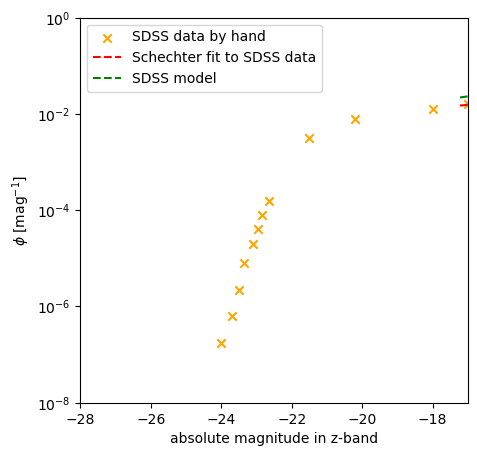

In [82]:
# since the plot from the SDSS paper isnt properly reproduced with the Schechter model from above, lets plot the data here (I read the data from the plot, so not so precise)

Schechter2 = models.Schechter1D()

fit_alg2 = fitting.LevMarLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail

schechter1D_fit2 = fit_alg2(Schechter2, mags_SDSS, dN)

print(schechter1D_fit2)

model2 = Schechter1D(schechter1D_fit2.phi_star.value, schechter1D_fit2.m_star.value, schechter1D_fit2.alpha.value)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(mags_SDSS, dN, label='SDSS data by hand', marker = "x", color = "orange")
ax.plot(center_abs_mags, schechter1D_fit2(center_abs_mags), label='Schechter fit to SDSS data', color = "red", linestyle = "dashed")
#ax.plot(center_abs_mags, model2(center_abs_mags), label='model from own fit data', color = "yellow", linestyle = "dashed")
ax.plot(center_abs_mags, model(center_abs_mags), label='SDSS model', color = "green", linestyle = "dashed")

ax.set_xlabel("absolute magnitude in z-band")
ax.set_ylabel("$\phi$ [mag$^{-1}]$")
ax.set_yscale('log')
ax.set_xlim(-28, -17)
ax.set_ylim(10**(-8),10**0)
ax.legend(loc = "upper left")

plt.show()

## Calculate and compare the covered luminosity, flux & mags after N galaxies (within DESI)

In [83]:
# first we define the luminosity funciton
def lum(M):
    return asc.L_bol0*np.exp(-0.4*M)/u.W

In [84]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity

# filter data from: https://arxiv.org/pdf/1804.08657.pdf
lmbda = 925*10**(-9) #in  m
del_lambda = 150*10**(-9) #in m
del_v = (asc.c*lmbda/(del_lambda**2)).value # this is in /s now
print(del_v)

m_sun = -27.74 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html

f_v = 10**((-48.6-m_sun)/2.5) # in erg/(cm^2 s Hz)
print(f_v)
dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v*del_v*4*np.pi*dist_sun**2 # this is  in erg/s, convert to W in function declaration
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z)

def lum_z(M):
    return L_sun_z*10**(-7)*np.exp(-0.4*M)

1.2324801051111108e+16
4.528975799036195e-09
1.5698312444893473e+35


In [85]:
N_galaxies = 10 # number of galaxies we can look at, 10 should be possible

### Flux

Calculating the flux is trivial: one just takes all the fluxes and sums over them (i.e. the real measured z-band flux from the DESI data) and compares them to the value one gets, if you only sum over the first N_galaxies values (by "first" I mean the highest values, therefore one has to sort the list)

In [86]:
sorted_fluxes =  np.sort(ztile_cat["FLUX_Z"])[::-1]
cov_flux = np.sum(sorted_fluxes[:N_galaxies])

In [87]:
cov_flux

1409.3314

In [88]:
total_flux = np.sum(sorted_fluxes) #this would of course also work with the original data

In [89]:
total_flux

1746.5668

In [90]:
print("After observing", N_galaxies, "galaxies we can cover ", cov_flux/total_flux*100, "% of the total flux in the search volume (comparison within DESI data)")

After observing 10 galaxies we can cover  80.6915283203125 % of the total flux in the search volume (comparison within DESI data)


### Magnitudes

Calculating the covered magnitudes is not really hard either: First get the magnitude range, which is covered within N_galaxies. This magnitude range is then compared to the total magnitude range. This is not scaled with the number (i.e. "density") in each bin, i.e.this calculation really just compares: covered range/total range

In [91]:
N_app_cum = np.cumsum(N_app)
N_abs_cum = np.cumsum(N_abs)

In [92]:
N_abs_cum[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [93]:
app_mag_cutoff_index = len(N_app_cum[N_app_cum<=N_galaxies])
abs_mag_cutoff_index = len(N_abs_cum[N_abs_cum<=N_galaxies])

In [94]:
app_mag_cutoff_index,  abs_mag_cutoff_index

(311, 295)

In [95]:
app_mag_sorted = np.sort(app_mag)
abs_mag_sorted = np.sort(abs_mag)

In [96]:
abs_mag_sorted[:5]

array([-17.2289128 , -16.81149271, -14.97919806, -14.97885444,
       -14.96583544])

In [97]:
cov_app_mag_rng = app_mag_sorted[app_mag_cutoff_index]-lower_limit_app
cov_abs_mag_rng = abs_mag_sorted[abs_mag_cutoff_index]-lower_limit_abs

IndexError: index 311 is out of bounds for axis 0 with size 38

In [ ]:
tot_app_mag_rng = upper_limit_app-lower_limit_app
tot_abs_mag_rng = upper_limit_app-lower_limit_app

In [ ]:
print("After observing", N_galaxies, "galaxies we can cover ", cov_app_mag_rng/tot_app_mag_rng*100, "% of the total apparent magnitude in the search volume (comparison within DESI data)")
print("After observing", N_galaxies, "galaxies we can cover ", cov_abs_mag_rng/tot_abs_mag_rng*100, "% of the total absolute magnitude in the search volume (comparison within DESI data)")

### Luminosity

- The first step is to calculate luminosity: $$ L = L_0 10^{-0.4*M_{Bol}}$$
Now this refers to the bolometric value. Technically, this is incorrect and one would have to calculate this for the z-band seperately, but since I am only working with z-band magnitudes and the relative comparison should be unaffected, since the only change occurs in the L_0 constant.
I did write code to adapt for this, but not completely sure, if this is right.

- Sum the covered luminosity
- Divide by total lum
- -> result


In [102]:
# first we define the luminosity funciton.
def lum(M):
    return asc.L_bol0*np.exp(-0.4*M)

In [103]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity
lmbda = 925*10**(-9) #in  m
del_lambda = 150*10**(-9) #in m
del_v = (asc.c*lmbda/(del_lambda**2)).value # this is in /s now
print(del_v)

m_sun = -27.74 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html

f_v = 10**((-48.6-m_sun)/2.5) # in erg/(cm^2 s Hz)
print(f_v)
dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v*del_v*4*np.pi*dist_sun**2 # this is  in erg/s, convert to W in function declaration
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z)

def lum_z(M):
    return L_sun_z*10**(-7)*np.exp(-0.4*M)*u.W

1.2324801051111108e+16
4.528975799036195e-09
1.5698312444893473e+35


In [104]:
# now calculate the luminosity of each galaxy

lums = [lum_z(abs_mag[q]).value for q in range(len(abs_mag))]

In [105]:
lums = np.sort(lums)

In [106]:
lums = lums[::-1]

In [107]:
lums[:5]

array([1.54462007e+31, 1.30709868e+31, 6.28067314e+30, 6.27980995e+30,
       6.24719221e+30])

In [108]:
len(lums), len(abs_mag)

(38, 38)

In [109]:
lums[:5], len(lums)

(array([1.54462007e+31, 1.30709868e+31, 6.28067314e+30, 6.27980995e+30,
        6.24719221e+30]),
 38)

In [110]:
tot_lums = np.sum(lums)
cov_lums = np.sum(lums[:N_galaxies])

In [111]:
tot_lums, cov_lums

(1.3963122833203151e+32, 7.384507004360724e+31)

In [112]:
print("After observing", N_galaxies, "galaxies we can cover ", cov_lums/tot_lums*100, "% of the total luminosity in the search volume (comparison within DESI data)")
print()
print("The total luminosity in this volume is: ", tot_lums)
print("We should be able to cover this amount of luminosity: ", cov_lums)
print("The cutoff was at luminosity: ", lums[abs_mag_cutoff_index], "while the max/min luminosity is: ", np.max(lums),"and", np.min(lums))

After observing 10 galaxies we can cover  52.885784165709524 % of the total luminosity in the search volume (comparison within DESI data)

The total luminosity in this volume is:  1.3963122833203151e+32
We should be able to cover this amount of luminosity:  7.384507004360724e+31


IndexError: index 295 is out of bounds for axis 0 with size 38

### Plot luminosity progress

In [ ]:
N_observed = np.arange(1,25)

In [ ]:
N_observed

In [ ]:
cov_lums_N = [np.sum(lums[:N_observed[q]]) for q in range(len(N_observed))]

In [ ]:
cov_lums_N[:5]

In [ ]:
"""
Explanation of this plot:

We want to estimate the amount of luminosity that we can cover after N observed galaxies within a certain 3D volume. This will be helpful e.g. for LIGO follow-up observations, since the LIGO
team will publish a 3D localization map of a GW-event. From there we take the 90% credible region and get all DESI observed galaxies in this volume. This plot now simply shows the percentage
of observed luminosity after one has observed the N most luminous galaxies compared to the total luminosity in this 3D volume. In future this should of course not be a comparison within DESI
data, but instead one needs to apply an incompleteness correction (e.g. 1/V_max, STY, SWML) to correct for missed galaxies in the sample. These numbers of course also heavily depend on the
3D localization by DESI. This data shown was extracted from GW190425, which had a 90% credible sky region of roughly 16deg^2, and a mean (luminosity) distance of 40Mpc with an error of
10Mpc (median z ~ 0.0093).

"""

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(N_observed, cov_lums_N/tot_lums*100, label = "")
ax.set_xlabel("Number of observed Galaxies")
ax.set_ylabel("Covered Luminosity in %")

ax.set_yscale('log')

plt.title("How much Luminosity is covered after N observed galaxies?")
plt.savefig("GW_plot", dpi = 600)
plt.show()

### Plotting luminosities

Plot the number densities depending of their luminosites:
- count objects in luminosity bins

In [ ]:
lower_limit_lum = np.min(lums)
upper_limit_lum = np.max(lums)
num_of_bins_lum = int( (upper_limit_lum-lower_limit_lum)/lower_limit_lum )

In [ ]:
num_of_bins_lum, lower_limit_lum, upper_limit_lum

In [ ]:
N_lum, lums_binned = np.histogram(lums, bins = num_of_bins_lum, range = (lower_limit_lum, upper_limit_lum))
N_lum[:10]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

width_lums = 0.7 * (lums_binned[1] - lums_binned[0])
center_lums = (lums_binned[:-1] + lums_binned[1:])/2

ax.bar(center_lums, N_lum,  align = "center", width = width_lums, label = "total number of galaxies per z-band luminosity")
ax.bar(center_lums, N_lum/area,  align = "center", width = width_lums, label = "normalized number of galaxies per z-band luminosity (per square deg)")

ax.set_xlabel("luminosity in z-band [W])")
y_label_abs = "N in " + str(width_lums) + "W width bins"
ax.set_ylabel(y_label_abs)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(lower_limit_lum, upper_limit_lum)
ax.legend(loc = "upper right")

plt.show()

# Calculate the covered luminosity after N galaxies (compared to "the universe")

# Calculate the covered luminosity after N galaxies (compared to own "universal" schechter fit)

This right now is a real problem, since I do not yet have this "universal" schechter function. Neither my own fit or the fit from the mentioned SDSS paper seem to agree that well and I think my region is large enough to actually get a meaningful result. Therefore I will try to create my own values, by simply taking the DESI data and using the whole available dataset. So we do a similar selection process as above and from there fit the schechter function.

In [ ]:
ztile_full = ztile_unm.copy()

In [ ]:
ztile_full.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_Z'])

In [ ]:
ztile_full = ztile_full[ztile_full['ZWARN']==0]

In [ ]:
ztile_full = ztile_full[(ztile_full['Z']>= 0)]

In [ ]:
ztile_full = ztile_full[ztile_full["FLUX_Z"] > 0.0]

In [ ]:
len(ztile_full)

In [ ]:
full_abs_mag = [(22.5-2.5*np.log10(ztile_full["FLUX_Z"][q]) - 5*np.log10(Distance(z=ztile_full["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_full["FLUX_Z"]))]

In [ ]:
full_abs_mags = np.sort(full_abs_mags)

In [ ]:
full_cumulated_galaxies = np.arange(1,len(full_abs_mags)-1, 1)

In [ ]:
# fit the model

schechter1D_full_fit = fit_alg(Schechter1D, full_abs_mags, real_cumulated_galaxies)